**Lasso Feature Selection**

Lasso selection is a feature selection technique used in linear regression models to identify the most important predictors or independent variables for a given dependent variable. The lasso (short for "Least Absolute Shrinkage and Selection Operator") method adds a penalty term to the traditional least squares regression equation, which helps to shrink or reduce the coefficients of less important variables towards zero.

The amount of shrinkage is controlled by a tuning parameter, which can be adjusted to balance between model complexity and accuracy. As a result, the lasso method can effectively handle high-dimensional data, where the number of predictors is much larger than the number of observations.

The lasso selection technique is particularly useful in situations where there may be a large number of potential predictors, but many of them are likely to be irrelevant or redundant. By shrinking the coefficients of less important predictors, the lasso method can identify a subset of predictors that are most strongly associated with the dependent variable, which can lead to a more accurate and interpretable regression model.

Overall, the lasso selection method can help to improve the efficiency and interpretability of linear regression models, particularly in high-dimensional data settings.

Found 2100 files belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 2000x1000 with 0 Axes>

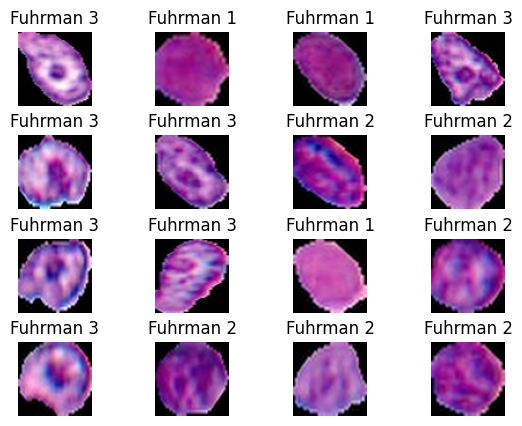

In [72]:
import os,math,random
import tensorflow as tf
import matplotlib.pyplot as plt
import time


path_to_images=os.path.join('..','dataset','Extracted Annotation Data','Cleared Image Patches')
batch_size=32
image_size=(64,64,3)


images = tf.keras.utils.image_dataset_from_directory(            
                directory=path_to_images,
                validation_split=None,
                subset=None,
                seed=1234,
                batch_size=batch_size,
                color_mode='rgb',
                image_size=image_size[:2],
                interpolation='lanczos5',
                crop_to_aspect_ratio=False
            )

class_names=os.listdir(path_to_images)
num_classes=len(class_names)
raw_images,labels=tuple(zip(*images))
bioimage_data,bioimage_labels=tf.concat([image for image in raw_images],0),tf.concat([label for label in labels],0)


plt.figure(figsize=(20,10))
fig,axs=plt.subplots(4,4)
random.seed(time.time())
images=[random.randint(0,bioimage_data.shape[0]-1) for _ in range(16)]
cnt=0
for j in range(len(images)):
    if j!=0 and j%int(math.sqrt(len(images)))==0:
        cnt+=1
    axs[cnt,j%int(math.sqrt(len(images)))].imshow(tf.cast(bioimage_data[j]/255, tf.float32))
    axs[cnt,j%int(math.sqrt(len(images)))].set_title(class_names[bioimage_labels[j]])
    axs[cnt,j%int(math.sqrt(len(images)))].set_axis_off()

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

## Feature Extraction

In [73]:
import numpy as np
from functools import reduce
import pandas as pd

base_model_name='vgg19'
lb,ub=0,16

base_model,pretrained_model_name=(tf.keras.applications.VGG16(weights='imagenet', input_shape=image_size, include_top=False),'VGG16') if base_model_name=='vgg16' else (tf.keras.applications.VGG19(weights='imagenet', input_shape=image_size, include_top=False),'VGG19') if base_model_name=='vgg19' else (tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=Dataset.image_size, include_top=False),'RESNET50') if base_model_name=='resnet50' else (tf.keras.applications.ResNet101V2(weights='imagenet', input_shape=image_size, include_top=False),'RESNET101')
base_model.trainable = True
for layer in base_model.layers[lb:ub]:
    layer.trainable = False
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=image_size,name='feature_extractor_input_layer'))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D(name='average_pooling_layer'))



pretrained_model_name = base_model_name
feature_set = list()
labels = list()
for i in range(0, bioimage_data.shape[0] // batch_size):
    batch_indeces = list(range(i, i + batch_size))
    batch_images = []

    for image_index in batch_indeces:
        image = np.array(bioimage_data[image_index])
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.imagenet_utils.preprocess_input(image)
        batch_images.append(image)

    batch_images = np.vstack(batch_images)
    features = model.predict(batch_images, batch_size=batch_size)
    output_shape = model.layers[-1].output.shape
    flatten_shape = reduce(lambda a, b: a * b, [x for x in list(output_shape) if type(x) == int])
    features = np.reshape(features, (-1, flatten_shape))
    feature_set.append(features)
    labels.append(np.array(bioimage_labels[i:i + batch_size]))

# Convert features and labels to arrays
feature_set = np.vstack(feature_set)
labels = np.hstack(labels)

# Save extracted features and labels to CSV file
data=list()
for i in range(feature_set.shape[0]):
    row=list()
    for j in range(feature_set.shape[1]):
        row.append(feature_set[i][j])
    row.append(labels[i])
    data.append(row)
bioimage_dataframe=pd.DataFrame(data,columns=[f'F{i+1}' for i in range(len(feature_set[0]))]+['Fuhrman'])
print(bioimage_dataframe.describe())


1/1 [==============================] - 0s 200ms/step
                F1           F2           F3           F4      F5  \
count  2080.000000  2080.000000  2080.000000  2080.000000  2080.0   
mean      0.074686     0.032095     1.228483     0.931910     0.0   
std       0.639516     0.256823     2.727589     2.876716     0.0   
min       0.000000     0.000000     0.000000     0.000000     0.0   
25%       0.000000     0.000000     0.000000     0.000000     0.0   
50%       0.000000     0.000000     0.000000     0.000000     0.0   
75%       0.000000     0.000000     0.516156     0.000000     0.0   
max       5.548085     2.086189    14.487286    19.642345     0.0   

                F6      F7           F8           F9          F10  ...  \
count  2080.000000  2080.0  2080.000000  2080.000000  2080.000000  ...   
mean      3.029237     0.0     0.195047     0.001383     0.093293  ...   
std       6.013142     0.0     0.906706     0.011068     0.594546  ...   
min       0.000000     0.0   

In [80]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna

features=bioimage_dataframe.columns.to_list()
target=features[-1]
features.remove(target)

X,Y=bioimage_dataframe[features],bioimage_dataframe[target]

train_indeces,test_indeces=train_test_split(bioimage_dataframe,test_size=0.14286)
xtrain=train_indeces[features]
xtest=test_indeces[features]
ytrain=train_indeces[target]
ytest=test_indeces[target]

class LassoSelector:
    def __init__(self,x_train,x_test,y_train,y_test):
        self.xtrain=x_train
        self.xtest=x_test
        self.ytrain=y_train
        self.ytest=y_test
        self.scaler=None
        self.alpha=None
    
    def set_params(self,**params):
        normalize_method=params['normalize']
        alpha_param=params['alpha']
        self.scaler=MinMaxScaler() if normalize_method=='MinMax' else StandardScaler() if normalize_method=='Standardization' else KNNImputer(n_neighbors=10)
        self.alpha=float(alpha_param)
        print(self.scaler)

        print(self.alpha)
    
    def callback(self,trial):
        normalize=trial.suggest_categorical('scaling_method',['MinMax','Standardization','KnnImpute'])
        alpha_param=trial.suggest_categorical('lasso_alpha',[str(x) for x in list(np.arange(0.5,20.0,0.5))])
        
        scaler=MinMaxScaler() if normalize=='MinMax' else StandardScaler() if normalize=='Standardization' else KNNImputer(n_neighbors=10)
        print(scaler)
        lasso_pipeline = Pipeline(
        steps=[
            ('scaler', scaler),
            ('lasso', Lasso(alpha=float(alpha_param),tol=1e-2,max_iter=10000))
        ],verbose=True)

        lasso_pipeline.fit(self.xtrain,self.ytrain)
        ypred=lasso_pipeline.predict(self.xtest)
        return mean_squared_error(self.ytest,ypred)

    def solve(self):
        study=optuna.create_study(direction='minimize')
        study.optimize(self.callback,n_trials=50)

        return study.best_params

    def lasso(self):
        print(self.scaler)
        lasso_pipeline = Pipeline(
        steps=[
            ('scaler', self.scaler),
            ('lasso', Lasso(alpha=self.alpha,tol=1e-2,max_iter=10000))
        ],verbose=True)

        lasso_pipeline.fit(self.xtrain,self.ytrain)
        self.xtrain=pd.DataFrame(data=lasso_pipeline.named_steps['scaler'].fit_transform(self.xtrain),columns=self.xtrain.columns.to_list())
        self.xtest=pd.DataFrame(data=lasso_pipeline.named_steps['scaler'].fit_transform(self.xtest),columns=self.xtest.columns.to_list())
        feature_coefficients=lasso_pipeline.named_steps['lasso'].coef_
        selected_columns=[column for i,column in enumerate(self.xtrain.columns.to_list()) if feature_coefficients[i]!=0]
        return (self.xtrain[selected_columns],self.xtest[selected_columns])


selector=LassoSelector(xtrain,xtest,ytrain,ytest)
params=selector.solve()
normalize_method,alpha_param=params['scaling_method'],params['lasso_alpha']
print(normalize_method,alpha_param)

[I 2023-03-08 18:34:59,503] A new study created in memory with name: no-name-28b74351-573c-494d-ad14-24463b0a0e9e
[I 2023-03-08 18:34:59,527] Trial 0 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'Standardization', 'lasso_alpha': '18.5'}. Best is trial 0 with value: 0.5722861625642899.
[I 2023-03-08 18:34:59,549] Trial 1 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'Standardization', 'lasso_alpha': '3.5'}. Best is trial 0 with value: 0.5722861625642899.
[I 2023-03-08 18:34:59,576] Trial 2 finished with value: 0.19886860853305752 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '4.0'}. Best is trial 2 with value: 0.19886860853305752.
[I 2023-03-08 18:34:59,596] Trial 3 finished with value: 0.11280150319714263 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '1.5'}. Best is trial 3 with value: 0.11280150319714263.
[I 2023-03-08 18:34:59,617] Trial 4 finished with value: 0.5722861625642899 and parameter

StandardScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
StandardScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
MinMaxScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
StandardScaler()
[

[I 2023-03-08 18:34:59,718] Trial 9 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,738] Trial 10 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,758] Trial 11 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,780] Trial 12 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,806] Trial 13 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:5

KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, 

[I 2023-03-08 18:34:59,889] Trial 17 finished with value: 0.4251481417754282 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '11.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,910] Trial 18 finished with value: 0.562542258489994 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '15.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,928] Trial 19 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'MinMax', 'lasso_alpha': '10.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,946] Trial 20 finished with value: 0.48994969608149386 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '13.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34:59,967] Trial 21 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:34

KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
MinMaxScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0

[I 2023-03-08 18:35:00,119] Trial 28 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'Standardization', 'lasso_alpha': '18.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,138] Trial 29 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'MinMax', 'lasso_alpha': '17.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,165] Trial 30 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'Standardization', 'lasso_alpha': '8.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,188] Trial 31 finished with value: 0.0728221958750736 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,210] Trial 32 finished with value: 0.2925187698257514 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '6.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-0

StandardScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
MinMaxScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
StandardScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neigh

[I 2023-03-08 18:35:00,292] Trial 36 finished with value: 0.3586105542011752 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '8.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,317] Trial 37 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'Standardization', 'lasso_alpha': '16.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,338] Trial 38 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '19.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,355] Trial 39 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'MinMax', 'lasso_alpha': '12.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,376] Trial 40 finished with value: 0.5722861625642899 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '15.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
StandardScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
MinMaxScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipelin

[I 2023-03-08 18:35:00,485] Trial 45 finished with value: 0.507756316507853 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '13.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,515] Trial 46 finished with value: 0.49183094290646556 and parameters: {'scaling_method': 'Standardization', 'lasso_alpha': '0.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,535] Trial 47 finished with value: 0.16294287403533153 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '3.0'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,555] Trial 48 finished with value: 0.18400795689631236 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '3.5'}. Best is trial 9 with value: 0.0728221958750736.
[I 2023-03-08 18:35:00,575] Trial 49 finished with value: 0.370639452579849 and parameters: {'scaling_method': 'KnnImpute', 'lasso_alpha': '9.0'}. Best is trial 9 with value: 0.0728221958750736.


StandardScaler()
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
KnnImpute 0.5


### Prediction

In [83]:
selector.set_params(normalize=normalize_method,alpha=alpha_param)
xtrain,xtest=selector.lasso()

KNNImputer(n_neighbors=10)
0.5
KNNImputer(n_neighbors=10)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s
F1       5.548085
F2       2.086189
F3      14.487286
F4      19.642345
F5       0.000000
          ...    
F508     9.544242
F509     1.247927
F510     0.000000
F511     0.134832
F512    28.655268
Length: 512, dtype: float32

F1       5.548083
F2       2.086188
F3      14.487286
F4      19.642345
F5       0.000000
          ...    
F508     9.544239
F509     0.000000
F510     0.000000
F511     0.000000
F512    28.655264
Length: 512, dtype: float32
['F57', 'F63', 'F64', 'F88', 'F111', 'F162', 'F227', 'F246', 'F248', 'F280', 'F322', 'F341', 'F357', 'F386', 'F423', 'F430', 'F440', 'F456', 'F475']


### New train test set

In [76]:
print(xtrain.describe(),end='\n\n')
print(xtest.describe(),end='\n\n')


               F44          F57          F63         F111         F227  \
count  1782.000000  1782.000000  1782.000000  1782.000000  1782.000000   
mean     24.999962    17.648987     6.777406    65.912407    45.820866   
std      17.641121    16.640999    14.923613    21.647308    22.100536   
min       0.000000     0.000000     0.000000    14.829313     1.596313   
25%       9.676541     4.370443     0.000000    50.361309    29.469219   
50%      23.423222    12.722010     0.153997    64.519638    43.981350   
75%      33.681702    30.208370     5.189285    80.580475    63.869389   
max      90.833527    70.387215    67.219810   121.142464    90.329704   

              F248         F322         F341         F357         F419  \
count  1782.000000  1782.000000  1782.000000  1782.000000  1782.000000   
mean     13.456172    39.712181    10.443316    53.684280    44.814861   
std      29.493298    24.111986    14.028958    38.107819    34.991524   
min       0.000000     0.000000     0

### Data distribution for each column

['F44', 'F57', 'F63', 'F111', 'F227', 'F248', 'F322', 'F341', 'F357', 'F419', 'F423', 'F430', 'F440', 'F456', 'F475']


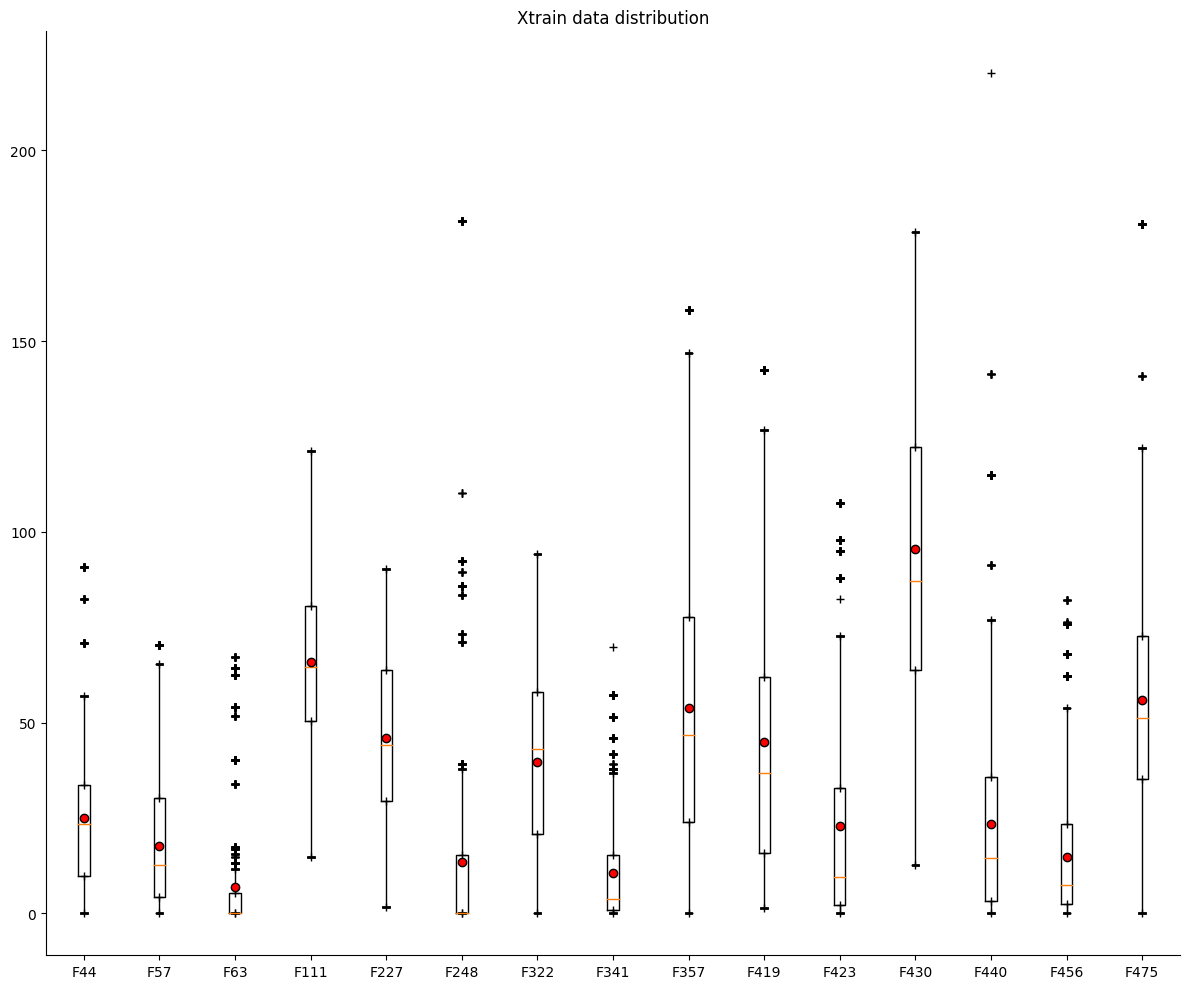

In [77]:
print(f'{xtrain.columns.to_list()}')

plt.figure(figsize=(12,10))
plt.title("Xtrain data distribution")
for j,column in enumerate(xtrain.columns.to_list()):
    plt.boxplot(xtrain[column].to_list(),positions=[j+1],showmeans=True,meanprops=dict(marker='o',markerfacecolor='red',markeredgecolor='black'), capprops=dict(linewidth=2,linestyle='-'), whiskerprops=dict(marker='+',markeredgecolor='black'),flierprops=dict(marker='+',markeredgecolor='black'))

plt.xticks(np.arange(1,xtrain.shape[1]+1),xtrain.columns.to_list())
plt.tight_layout()
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()